## Getting the data

You can download the dataset as a zip file from here:

[DOWNLOAD LINK](https://mega.nz/file/omlVQJrB#OJGx0r90H4ymNt7ZhikVGmroQFN0TDvgnH5ssIjRuJ0)

Unzip:

In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
replace videos/run/daria_run.avi? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: videos/run/daria_run.avi  
replace videos/run/ido_run.avi? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace videos/run/ido_run.avi? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: videos/run/ido_run.avi  
  inflating: videos/run/lena_run1.avi  
  inflating: videos/run/denis_run.avi  
  inflating: videos/run/eli_run.avi  
  inflating: videos/run/moshe_run.avi  
  inflating: videos/run/lena_run2.avi  
  inflating: videos/run/lyova_run.avi  
  inflating: videos/run/ira_run.avi  
  inflating: videos/run/shahar_run.avi  
  inflating: videos/wave1/ira_wave1.avi  
  inflating: videos/wave1/ido_wave1.avi  
  inflating: videos/wave1/lena_wave1.avi  
  inflating: videos/wave1/lyova_wave1.avi  
  inflating: videos/wave1/moshe_wave1.avi  
  inflating: videos/wave1/eli_wave1.avi  
  inflating: videos/wave1/denis_wave1.avi  
  inflating: videos/wave1/shahar_wa

In [ ]:
!pip install av
from torchvision.io import read_video, write_video
import matplotlib.pyplot as plt

# we select one of the video arbitrarily
video_avi, _, fps = read_video('videos/walk/daria_walk.avi', pts_unit='sec')

# note the shape of the output tensor
print(video_avi.shape)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 19.7 MB/s eta 0:00:00
torch.Size([84, 144, 180, 3])


The 10 classes of the Weizmenn dataset are as follows:

In [ ]:
classes = {
    0: 'walk',
    1: 'run',
    2: 'jump',
    3: 'side',
    4: 'bend',
    5: 'wave1',
    6: 'wave2',
    7: 'pjump',
    8: 'jack',
    9: 'skip'
    }

Imports

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.io import read_video
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torchvision.models as models

# Data Proccesing

## Video Splitting Strategy

In my approach to video splitting, I initially relied on simple random sampling, which selected arbitrary subsequences from each video. However, this method proved problematic as it often oversampled certain temporal regions while completely missing others.

I then tried a more systematic strategy that divides each original video into 5 equal segments and samples one subsequence from each, with randomized start positions and lengths (between 5 and 50 frames). This strategic sampling technique ensures comprehensive temporal coverage of the entire action while maintaining randomization, effectively balancing structure with variability.

The improved approach offers several key advantages: it guarantees representation from all temporal phases of an action (beginning, middle, and end), prevents bias from oversampling particular segments, and creates a more diverse training dataset with varied sequence lengths. This methodical yet flexible sampling strategy significantly enhanced the model's ability to recognize actions regardless of their temporal position or duration, improving its generalization capabilities.

In [ ]:
#First design, uses random sampling
def split_video_v1(video_tensor, min_frames=5, max_frames=50):
    total_frames = video_tensor.shape[0]
    subvideos = []
    for _ in range(5):  # Split each video into 5 subvideos
        start_frame = np.random.randint(0, max(1, total_frames - min_frames))
        length = np.random.randint(min_frames, min(max_frames, total_frames - start_frame) + 1)
        subvideo = video_tensor[start_frame:start_frame + length]
        subvideos.append(subvideo)
    return subvideos


# Currently used
def split_video(video_tensor, min_frames=5, max_frames=50, n_splits=5):
  total_frames = len(video_tensor)
  if total_frames < min_frames:
      return []

  subvideos = []
  segment_length = total_frames // n_splits

  for i in range(n_splits):
      # Calculate segment boundaries
      start_idx = i * segment_length
      end_idx = min((i + 1) * segment_length, total_frames)

      # Ensure minimum length
      if end_idx - start_idx < min_frames:
          continue

      # Random length between min_frames and max_frames
      length = random.randint(min_frames, min(max_frames, end_idx - start_idx))

      # Random start within segment
      available_start = end_idx - length
      if available_start > start_idx:
          start = random.randint(start_idx, available_start)
      else:
          start = start_idx

      subvideo = video_tensor[start:start + length]
      subvideos.append(subvideo)

  return subvideos

## Temporal-Consistent Data Augmentation

My data augmentation strategy focuses on maintaining temporal consistency, which is critical for action recognition. The key insight is that transformations must be applied identically across all frames in a sequence to preserve the natural motion patterns that distinguish different actions.

### Evolution of my approach:

1. **Initial Implementation**: My first version applied standard image augmentations independently to each frame, which disrupted temporal coherence and negatively impacted model performance.

2. **Temporal-Consistent Transformations**: I redesigned the augmentation pipeline to apply identical transformations to all frames in a sequence. This preserves motion patterns crucial for differentiating similar actions (e.g., "walk" vs. "run").

3. **Data Format Optimization**: I restructured the tensor format to (C, T, H, W) to optimize for 3D CNN processing, enabling the model to effectively learn spatiotemporal features.

The implementation directly reflects this philosophy through custom transformation classes that maintain consistency across frames. The ActionDataset class handles both video loading and preprocessing, with a specialized __getitem__ method that implements adaptive temporal sampling - either downsampling longer sequences using linear interpolation or extending shorter ones by repeating the final frames rather than using zero padding, which could introduce artificial motion boundaries.

For the transformations, I created three custom classes: TemporalConsistentRandomHorizontalFlip, TemporalConsistentRandomRotation, and TemporalConsistentColorJitter. Each applies the exact same transformation parameters to all frames in a sequence. For example, the color jitter class computes a single set of brightness, contrast, saturation, and hue factors that are then applied identically to every frame, preserving the video's natural color progression.

The transformation pipeline first converts the input from (T, H, W, C) format to (T, C, H, W), then applies center cropping to maintain aspect ratio, followed by resizing to a uniform 128×128. Notably, the commented-out transformations indicate my experimental process - I initially implemented more aggressive augmentations but found they were detrimental to temporal consistency, so I ultimately disabled them in favor of a more conservative approach. The pipeline concludes with normalization using mean and standard deviation computed across spatial and temporal dimensions, and a final tensor reshaping to (C, T, H, W) format to optimize for the CNN-LSTM architecture.



In [ ]:
class ActionDataset(Dataset):
    def __init__(self, root_dir, classes, min_frames=5, max_frames=50, transform=None):
        self.root_dir = root_dir
        self.classes = classes
        self.min_frames = min_frames
        self.max_frames = max_frames
        self.transform = transform
        self.data = []
        self.labels = []
        self.prepare_data()

    def prepare_data(self):
        for label, action in self.classes.items():
            action_dir = os.path.join(self.root_dir, action)
            for video_file in os.listdir(action_dir):
                video_path = os.path.join(action_dir, video_file)
                try:
                    video_tensor, _, _ = read_video(video_path, pts_unit='sec')
                    subvideos = split_video(video_tensor,
                                                   self.min_frames,
                                                   self.max_frames)
                    for subvideo in subvideos:
                        self.data.append(subvideo)
                        self.labels.append(label)
                except Exception as e:
                    print(f"Error reading {video_path}: {e}")

    def __getitem__(self, idx):
        video = self.data[idx]
        label = self.labels[idx]

        # Adaptive temporal sampling
        if len(video) > self.max_frames:
            indices = torch.linspace(0, len(video)-1, self.max_frames).long()
            video = video[indices]
        elif len(video) < self.max_frames:
            # Repeat last frames instead of zero padding
            repeats = self.max_frames - len(video)
            video = torch.cat([video, video[-1:].repeat(repeats, 1, 1, 1)])

        # Apply temporally consistent transforms
        video = self.transform(video)

        return video, label

    def __len__(self):
        return len(self.data)

In [ ]:
# Transformation
class TemporalConsistentRandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, video):
        if random.random() < self.p:
            return transforms.functional.hflip(video)
        return video

class TemporalConsistentRandomRotation:
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, video):
        angle = random.uniform(-self.degrees, self.degrees)
        return transforms.functional.rotate(video, angle)

class TemporalConsistentColorJitter:
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue

    def __call__(self, video):
        brightness_factor = random.uniform(1-self.brightness, 1+self.brightness)
        contrast_factor = random.uniform(1-self.contrast, 1+self.contrast)
        saturation_factor = random.uniform(1-self.saturation, 1+self.saturation)
        hue_factor = random.uniform(-self.hue, self.hue)

        video = transforms.functional.adjust_brightness(video, brightness_factor)
        video = transforms.functional.adjust_contrast(video, contrast_factor)
        video = transforms.functional.adjust_saturation(video, saturation_factor)
        video = transforms.functional.adjust_hue(video, hue_factor)
        return video

transform = transforms.Compose([
    # Input is (T, H, W, C)
    transforms.Lambda(lambda x: x.permute(0, 3, 1, 2).float() / 255.0),  # to (T, C, H, W)

    # Maintain aspect ratio by center cropping or padding
    transforms.Lambda(lambda x: transforms.functional.center_crop(x, [144, 144])),  # Assuming original is 144x180
    transforms.Lambda(lambda x: transforms.functional.resize(x, (128, 128))),

    # Temporal Consistent Spatial Augmentations
    #TemporalConsistentRandomHorizontalFlip(p=0.1),#disabled

    # Reduce rotation degrees or remove
    #TemporalConsistentRandomRotation(degrees=1),#disabled

    # Reduced Color Jittering
    #TemporalConsistentColorJitter(brightness=0.01, contrast=0.01, saturation=0.01, hue=0),#disabled

    # Normalize
    transforms.Lambda(lambda x: (x - x.mean(dim=(0,2,3), keepdim=True)) /
                               (x.std(dim=(0,2,3), keepdim=True) + 1e-6)),

    # Final permutation to (C, T, H, W)
    transforms.Lambda(lambda x: x.permute(1, 0, 2, 3))
])


## Evolution of Model Architecture

After searching simmilar action classification model, I choose to implement CNN-LSTM architecture, as it addresses the dual spatial-temporal nature of action recognition by combining CNNs for frame-level feature extraction with LSTMs for temporal sequence modeling. This hybrid approach efficiently decomposes video classification into manageable subtasks while offering better computational efficiency than 3D CNNs and more powerful representation capabilities than pure RNNs or CNNs alone.

My approach to use model architecture evolved through three main iterations, each addressing specific challenges in action recognition:

### 1. CNN_LSTMv1:
- Simple 3-layer CNN for frame-level feature extraction
- 2-layer LSTM for temporal sequence modeling
- Sequential frame-by-frame processing (inefficient)
- Limitations: Computationally expensive, lacked normalization, needed to learn visual features from scratch

### 2. CNN_LSTMv2:
- Added BatchNorm layers for training stability
- Implemented dropout in LSTM to reduce overfitting
- Restructured to process all frames simultaneously
- Dramatic improvement in computational efficiency

### 3. CNN_LSTM (Final):
- Leverages pre-trained ResNet18 to extract high-quality spatial features
- Dimension-reduction layer (512→256) between CNN and LSTM
- Strategic dropout throughout the network
- 3-layer LSTM for improved temporal modeling
- Strong classifier head with two fully-connected layers

## Architecture Justification

1. **Transfer Learning**: The pre-trained ResNet18 backbone provides high-quality visual features learned from millions of ImageNet images, addressing the limited data challenge.

2. **Feature Dimension Reduction**: The intermediate FC layer reduces feature dimensions from 512 to 256, decreasing model parameters while retaining essential information.

3. **Temporal Modeling**: The 3-layer LSTM effectively captures complex temporal dependencies in human actions.

4. **Regularization Strategy**: Dropout layers (0.3 in LSTM, 0.5 in FC layers) prevent overfitting, critical with our small dataset.

5. **Classification Head**: The two-layer classifier (128→num_classes) with ReLU activation adds non-linearity for better class separation.

This architecture effectively balances the need for powerful feature extraction with efficient temporal modeling while maintaining robust generalization on limited training data.

In [ ]:
# Currently Used
class CNN_LSTM(nn.Module):
    def __init__(self, num_classes=10, lstm_hidden_size=128, lstm_num_layers=3, pretrained=True): # layers 2->3
        super(CNN_LSTM, self).__init__()

        # 1. Pretrained CNN (ResNet18) for Feature Extraction
        resnet = models.resnet18(pretrained=pretrained)
        # Remove the final fully connected layer
        modules = list(resnet.children())[:-1]  # remove the last FC layer
        self.cnn = nn.Sequential(*modules)      # feature extractor

        # Freeze the CNN weights
        for param in self.cnn.parameters():
            param.requires_grad = True # unfrozen

        # 2. Intermediate Fully Connected Layer to Reduce Feature Dimensions
        # ResNet18 outputs features of size 512 after Global Average Pooling
        self.fc1 = nn.Linear(512, 256)
        self.relu = nn.ReLU()
        self.dropout_fc = nn.Dropout(0.5)

        # 3. LSTM to Process Sequence of Features
        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            batch_first=True,
            dropout=0.3  # Dropout between LSTM layers
        )

        # 4. Fully Connected Layer for Classification
        self.fc2 = nn.Sequential(
            nn.Linear(lstm_hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        """
        Forward pass of the CNN_LSTM model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels=3, frames=50, height=128, width=128)

        Returns:
            torch.Tensor: Output logits of shape (batch_size, num_classes)
        """
        batch_size, channels, frames, height, width = x.size()

        # Reshape to process all frames through CNN at once
        # New shape: (batch_size * frames, channels, height, width)
        x = x.permute(0, 2, 1, 3, 4).contiguous().view(batch_size * frames, channels, height, width)

        # Pass through CNN (ResNet18)
        with torch.no_grad():  # Freeze CNN during training
            features = self.cnn(x)  # Shape: (batch_size * frames, 512, 1, 1)

        # Remove the extra dimensions and reshape
        features = features.view(batch_size, frames, 512)  # Shape: (batch_size, frames, 512)

        # Pass through intermediate FC layer
        features = self.fc1(features)     # Shape: (batch_size, frames, 256)
        features = self.relu(features)
        features = self.dropout_fc(features)

        # Pass through LSTM
        lstm_out, (h_n, c_n) = self.lstm(features)  # lstm_out: (batch_size, frames, lstm_hidden_size)

        # Use the last output from LSTM
        lstm_last = lstm_out[:, -1, :]  # Shape: (batch_size, lstm_hidden_size)

        # Pass through final FC layers for classification
        output = self.fc2(lstm_last)     # Shape: (batch_size, num_classes)

        return output

# Unused
class CNN_LSTMv1(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_LSTM, self).__init__()
        # CNN to extract features
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # Input channels = 3
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # LSTM to process sequence of features
        self.lstm = nn.LSTM(input_size=64 * 16 * 16, hidden_size=128, num_layers=2, batch_first=True)
        # Fully connected layer for classification
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        batch_size, channels, frames, height, width = x.size()
        c_out = []
        for t in range(frames):
            frame = x[:, :, t, :, :]  # Get frame t
            c = self.cnn(frame)  # Apply CNN
            c = c.view(c.size(0), -1)  # Flatten
            c_out.append(c)
        c_out = torch.stack(c_out, dim=1)  # Shape: (batch, frames, features)
        lstm_out, _ = self.lstm(c_out)
        lstm_out = lstm_out[:, -1, :]  # Take the last output
        out = self.fc(lstm_out)
        return out

# Unused
class CNN_LSTMv2(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_LSTM, self).__init__()
        # CNN to extract features
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)  # Output: 64 x 16 x 16
        )

        # Calculate CNN output features
        self.cnn_output_size = 64 * 16 * 16

        # LSTM to process sequence of features
        self.lstm = nn.LSTM(
            input_size=self.cnn_output_size,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            dropout=0.5  # Added dropout between LSTM layers
        )

        # Fully connected layer for classification
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # Input x shape: (batch_size, channels=3, frames=50, height=128, width=128)
        batch_size, channels, frames, height, width = x.shape

        # Reshape to process all frames through CNN at once
        x = x.permute(0, 2, 1, 3, 4)  # (batch, frames, channels, height, width)
        x = x.contiguous().view(batch_size * frames, channels, height, width)

        # Pass through CNN
        x = self.cnn(x)  # Shape: (batch*frames, 64, 16, 16)

        # Reshape for LSTM
        x = x.view(batch_size * frames, -1)  # Flatten CNN output
        x = x.view(batch_size, frames, -1)  # Reshape to (batch, frames, features)

        # Pass through LSTM
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Use the last output from LSTM
        x = lstm_out[:, -1, :]  # Shape: (batch, 128)

        # Pass through final fully connected layers
        x = self.fc(x)

        return x

# Training Methodology

## Cross-Validation Training Strategy

For this action classification task, Due to the small nature of the Weizmann
 data set, I implemented a robust 5-fold Stratified Cross-Validation approach to ensure reliable model evaluation. This strategy offers several advantages:

1. **Balanced Class Distribution**: The stratified approach maintains consistent class distribution across all folds, preventing training bias.

2. **Efficient Resource Utilization**: With a batch size of 16 (optimized for GPU memory constraints), multi-worker data loading, and GPU pinning, the training pipeline maximizes computational efficiency.

3. **Comprehensive Hyperparameter Optimization**: The training loop incorporates:
   - AdamW optimizer with weight decay (1e-4) for effective regularization
   - ReduceLROnPlateau learning rate scheduler that adapts based on validation accuracy
   - Patience-based early stopping (10 epochs) to prevent overfitting while conserving computation

4. **Loss Function Selection**: I chose CrossEntropyLoss because it:
   - Is well-suited for our multi-class classification problem with 10 distinct action categories
   - Provides effective gradients for optimizing class boundaries

5. **Model Persistence**: The pipeline saves only the best-performing model from each fold based on validation accuracy, ensuring we retain only the most generalizable parameters.

This comprehensive approach balances the need for thorough evaluation with the practical constraints of limited data and computational resources, resulting in a robust training methodology for action recognition, resulting in a best validation accuaracy of 0.7733 and an average of 0.6411.

## Learning rate optimization experiment

To find the optimal learning rate for my model, I conducted a systematic experiment evaluating several learning rates (0.001, 0.0001, 0.00001, 0.000001) using 5-fold cross-validation. This approach allowed me to identify which learning rate provided the best balance between convergence speed and stability.

The experiment revealed that a learning rate of 0.0002 yielded the best performance. This moderate learning rate allows the model to:
1. Make sufficiently large parameter updates to escape local minima
2. Maintain stability without overshooting optimal values
3. Converge efficiently given our limited training resources and data

I also experimented with different optimizers (AdamW, SGD), weight decay values, momentum settings, and learning rate schedulers (ReduceLROnPlateau, StepLR) before selecting my final configuration. This systematic approach to hyperparameter optimization was crucial for achieving robust performance on the Weizmann dataset.
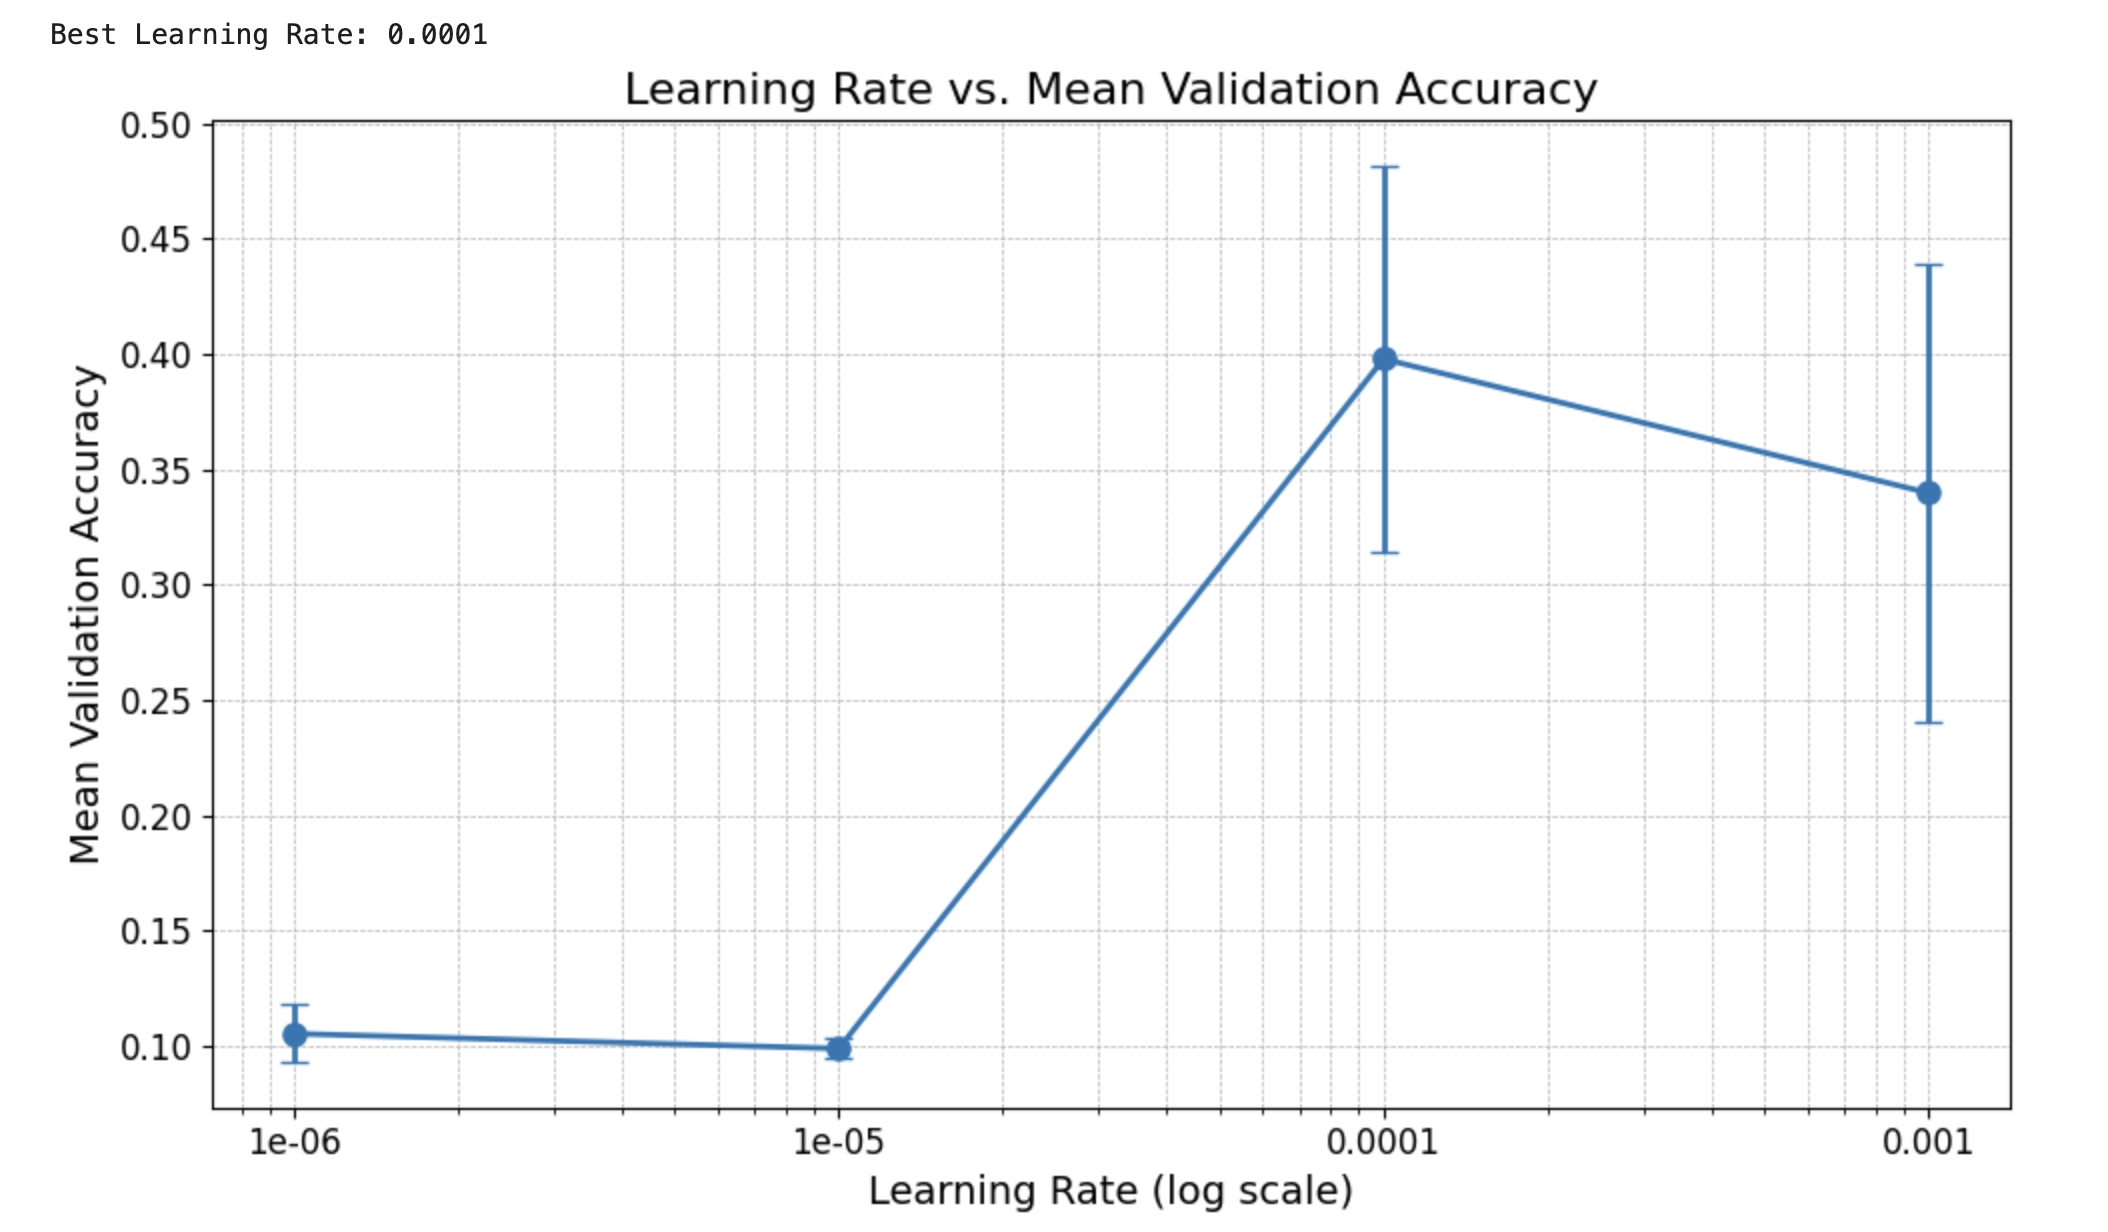


In [ ]:
# Learning rate optimization
def perform_learning_rate_search():
    from sklearn.model_selection import StratifiedKFold
    from torch.utils.data import Subset
    from collections import Counter
    import numpy as np
    import matplotlib.pyplot as plt

    # Initialize the full dataset
    full_dataset = ActionDataset(root_dir='videos', classes=classes, transform=transform)

    # Define Cross-Validation Parameters
    k_folds = 5
    kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Set Batch Size
    batch_size = 16

    # Initialize a dictionary to store DataLoaders for each fold
    data_loaders = {
        'train': [],
        'val': []
    }

    # Convert labels to a NumPy array for StratifiedKFold
    labels = np.array(full_dataset.labels)

    # Iterate through each fold
    for fold, (train_ids, val_ids) in enumerate(kfold.split(np.zeros(len(labels)), labels)):
        # Define subsets for training and validation
        train_subsampler = Subset(full_dataset, train_ids)
        val_subsampler = Subset(full_dataset, val_ids)

        # Create DataLoaders for the current fold
        train_loader = DataLoader(
            train_subsampler,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,          # Adjust based on your system
            pin_memory=True if torch.cuda.is_available() else False
        )

        val_loader = DataLoader(
            val_subsampler,
            batch_size=batch_size,
            shuffle=False,
            num_workers=2,          # Adjust based on your system
            pin_memory=True if torch.cuda.is_available() else False
        )

        # Append the DataLoaders to the dictionary
        data_loaders['train'].append(train_loader)
        data_loaders['val'].append(val_loader)

        print(f'Fold {fold+1} - Training samples: {len(train_subsampler)}')
        print(f'Fold {fold+1} - Validation samples: {len(val_subsampler)}\n')

    # Define the learning rates to try
    learning_rates = [0.001, 0.0001, 0.00001, 0.000001]

    # Dictionary to track results across different learning rates
    results = {lr: [] for lr in learning_rates}

    # Train for each learning rate
    for lr in learning_rates:
        print(f'\n--- Training with Learning Rate: {lr} ---')

        # Example Usage in Training Loop:
        for fold in range(k_folds):
            print(f'\nStarting Fold {fold+1}/{k_folds}')
            train_loader = data_loaders['train'][fold]
            val_loader = data_loaders['val'][fold]

            # Initialize your model, loss function, optimizer, scheduler
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = CNN_LSTM(num_classes=10).to(device)
            criterion = nn.CrossEntropyLoss()

            # Use the current learning rate
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
            num_epochs = 15 # smaller for experiment

            # Early stopping (finding optimal epoch)
            patience = 10
            trigger_times = 0

            best_val_accuracy = 0.0
            best_model_path = f'best_model_lr_{lr}_fold_{fold+1}.pth'

            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                correct = 0
                total = 0

                for inputs, labels in train_loader:
                    inputs = inputs.to(device)  # Shape: (batch, C, T, H, W)
                    labels = labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(inputs)     # Shape: (batch, num_classes)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                scheduler.step()

                epoch_loss = running_loss / total
                epoch_acc = correct / total

                # Validation Phase
                model.eval()
                val_correct = 0
                val_total = 0
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = model(inputs)
                        _, predicted = torch.max(outputs, 1)
                        val_total += labels.size(0)
                        val_correct += (predicted == labels).sum().item()

                val_accuracy = val_correct / val_total

                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    torch.save(model.state_dict(), best_model_path)
                    trigger_times = 0
                else:
                    trigger_times += 1
                    if trigger_times >= patience:
                        print('Early stopping!')
                        break

                print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, '
                      f'Training Acc: {epoch_acc:.4f}, Validation Acc: {val_accuracy:.4f}')

            print(f'Best Validation Accuracy for LR {lr}, Fold {fold+1}: {best_val_accuracy:.4f}\n')
            results[lr].append(best_val_accuracy)

    # Calculate and display average results for each learning rate
    print("\n--- Learning Rate Comparison ---")
    for lr, accuracies in results.items():
        avg_accuracy = sum(accuracies) / len(accuracies)
        print(f"Learning Rate {lr}: Average Validation Accuracy = {avg_accuracy:.4f}")

    # Find the best learning rate
    best_lr = max(results.items(), key=lambda x: sum(x[1])/len(x[1]))[0]
    print(f"\nBest Learning Rate: {best_lr}")

    # Prepare data for plotting
    mean_accuracies = []
    std_accuracies = []
    for lr in learning_rates:
        mean_acc = np.mean(results[lr])
        std_acc = np.std(results[lr])
        mean_accuracies.append(mean_acc)
        std_accuracies.append(std_acc)

    # Plotting Learning Rate vs. Validation Accuracy
    plt.figure(figsize=(10, 6))
    plt.errorbar(learning_rates, mean_accuracies, yerr=std_accuracies, fmt='-o', capsize=5, markersize=8, linewidth=2)
    plt.xscale('log')
    plt.xlabel('Learning Rate (log scale)', fontsize=14)
    plt.ylabel('Mean Validation Accuracy', fontsize=14)
    plt.title('Learning Rate vs. Mean Validation Accuracy', fontsize=16)
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.xticks(learning_rates, labels=[str(lr) for lr in learning_rates], fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('learning_rate_comparison.png')  # Save the plot as an image
    plt.show()

    return best_lr

# Uncomment to run experiment
# best_learning_rate = perform_learning_rate_search()

## Cross Validation Training

In [ ]:
# Flag to control training
TRAIN_MODEL = False

Data Spliting ( Training + Validation 80% / Test 20)

In [ ]:
def prepare_datasets(test_size=0.2, random_state=42):
    from sklearn.model_selection import train_test_split

    # Initialize the full dataset
    full_dataset = ActionDataset(root_dir='videos', classes=classes, transform=transform)

    # Get indices for all samples
    indices = list(range(len(full_dataset)))

    # Get labels for stratification
    labels = np.array(full_dataset.labels)

    # Split into train+val set and test set
    train_val_indices, test_indices = train_test_split(
        indices, test_size=test_size,
        stratify=labels, random_state=random_state
    )

    # Create datasets using these indices
    train_val_dataset = Subset(full_dataset, train_val_indices)
    test_dataset = Subset(full_dataset, test_indices)

    print(f"Total samples: {len(full_dataset)}")
    print(f"Train+Validation samples: {len(train_val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    return train_val_dataset, test_dataset

Training Loop Function

In [ ]:
# First, get the train_val_dataset and test_dataset from prepare_datasets
train_val_dataset, test_dataset = prepare_datasets(test_size=0.2, random_state=42)

# Create a test loader for the separate test set
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

def train_with_cross_validation(train_model=False):
    # Use the global train_val_dataset defined above
    dataset = train_val_dataset

    # Get labels for stratification
    # We need to handle Subset objects differently
    if isinstance(dataset, torch.utils.data.Subset):
        # For a Subset, get labels from the dataset's indices
        original_dataset = dataset.dataset
        indices = dataset.indices
        labels = np.array([original_dataset.labels[i] for i in indices])
    else:
        # For the original dataset
        labels = np.array(dataset.labels)

    # Define Cross-Validation Parameters
    k_folds = 5
    kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Set Batch Size
    batch_size = 16

    # Initialize a dictionary to store DataLoaders for each fold
    data_loaders = {
        'train': [],
        'val': []
    }

    # Iterate through each fold
    for fold, (train_ids, val_ids) in enumerate(kfold.split(np.zeros(len(labels)), labels)):
        # Define subsets for training and validation
        train_subsampler = Subset(dataset, train_ids)
        val_subsampler = Subset(dataset, val_ids)

        # Create DataLoaders for the current fold
        train_loader = DataLoader(
            train_subsampler,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=True if torch.cuda.is_available() else False
        )

        val_loader = DataLoader(
            val_subsampler,
            batch_size=batch_size,
            shuffle=False,
            num_workers=2,
            pin_memory=True if torch.cuda.is_available() else False
        )

        # Append the DataLoaders to the dictionary
        data_loaders['train'].append(train_loader)
        data_loaders['val'].append(val_loader)

        print(f'Fold {fold+1} - Training samples: {len(train_subsampler)}')
        print(f'Fold {fold+1} - Validation samples: {len(val_subsampler)}\n')

    # Add the test loader to the data_loaders dictionary
    data_loaders['test'] = test_loader

    # Initialize lists to store metrics for all folds
    fold_train_losses = []
    fold_train_accuracies = []
    fold_val_losses = []
    fold_val_accuracies = []

    if train_model:
        #Training Loop
        for fold in range(k_folds):
            print(f'\nStarting Fold {fold+1}/{k_folds}')
            train_loader = data_loaders['train'][fold]
            val_loader = data_loaders['val'][fold]

            # Initialize your model, loss function, optimizer, scheduler
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = CNN_LSTM(num_classes=10).to(device)
            criterion = nn.CrossEntropyLoss()

            learning_rate = 0.0002
            optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
            #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
            #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
            num_epochs = 40

            # Early stopping (finding optimal epoch)
            patience = 10
            trigger_times = 0

            best_val_accuracy = 0.0
            best_model_path = f'best_model_fold_{fold+1}.pth'

            # Initialize lists to store metrics for this fold
            train_losses = []
            train_accuracies = []
            val_losses = []
            val_accuracies = []

            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                correct = 0
                total = 0

                for inputs, labels in train_loader:
                    inputs = inputs.to(device)  # Shape: (batch, C, T, H, W)
                    labels = labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(inputs)     # Shape: (batch, num_classes)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                epoch_loss = running_loss / total
                epoch_acc = correct / total

                scheduler.step(epoch_acc)

                # Append training metrics
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)

                # Validation Phase
                model.eval()
                val_running_loss = 0.0
                val_correct = 0
                val_total = 0
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        val_running_loss += loss.item() * inputs.size(0)
                        _, predicted = torch.max(outputs, 1)
                        val_total += labels.size(0)
                        val_correct += (predicted == labels).sum().item()

                val_epoch_loss = val_running_loss / val_total
                val_epoch_acc = val_correct / val_total

                # Append validation metrics
                val_losses.append(val_epoch_loss)
                val_accuracies.append(val_epoch_acc)

                if val_epoch_acc > best_val_accuracy:
                    best_val_accuracy = val_epoch_acc
                    torch.save(model.state_dict(), best_model_path)
                    trigger_times = 0
                else:
                    trigger_times += 1
                    if trigger_times >= patience:
                        print('Early stopping!')
                        break

                print(f'Epoch {epoch+1}/{num_epochs}, '
                      f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
                      f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

            print(f'Best Validation Accuracy for Fold {fold+1}: {best_val_accuracy:.4f}\n')

            # After training, append the fold's metrics to the overall lists
            fold_train_losses.append(train_losses)
            fold_train_accuracies.append(train_accuracies)
            fold_val_losses.append(val_losses)
            fold_val_accuracies.append(val_accuracies)
    else:
        print("Training skipped. Set train_model=True to enable training.")

    return fold_train_losses, fold_train_accuracies, fold_val_losses, fold_val_accuracies, data_loaders

Total samples: 465
Train+Validation samples: 372
Test samples: 93


In [ ]:
# Run the training process with the flag controlling execution
fold_train_losses, fold_train_accuracies, fold_val_losses, fold_val_accuracies, data_loaders = train_with_cross_validation(train_model=TRAIN_MODEL)

Fold 1 - Training samples: 297
Fold 1 - Validation samples: 75

Fold 2 - Training samples: 297
Fold 2 - Validation samples: 75

Fold 3 - Training samples: 298
Fold 3 - Validation samples: 74

Fold 4 - Training samples: 298
Fold 4 - Validation samples: 74

Fold 5 - Training samples: 298
Fold 5 - Validation samples: 74


Starting Fold 1/5


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/40, Train Loss: 2.3066, Train Acc: 0.0741, Val Loss: 2.3038, Val Acc: 0.1067
Epoch 2/40, Train Loss: 2.3042, Train Acc: 0.1044, Val Loss: 2.3002, Val Acc: 0.0933
Epoch 3/40, Train Loss: 2.2944, Train Acc: 0.1380, Val Loss: 2.2838, Val Acc: 0.1333
Epoch 4/40, Train Loss: 2.2606, Train Acc: 0.2323, Val Loss: 2.2091, Val Acc: 0.1600
Epoch 5/40, Train Loss: 2.1221, Train Acc: 0.1987, Val Loss: 2.2342, Val Acc: 0.1600
Epoch 6/40, Train Loss: 2.0790, Train Acc: 0.2323, Val Loss: 1.9781, Val Acc: 0.2667
Epoch 7/40, Train Loss: 1.9523, Train Acc: 0.2559, Val Loss: 1.8999, Val Acc: 0.2533
Epoch 8/40, Train Loss: 1.9793, Train Acc: 0.2492, Val Loss: 1.8581, Val Acc: 0.2667
Epoch 9/40, Train Loss: 1.8031, Train Acc: 0.2997, Val Loss: 1.8036, Val Acc: 0.2933
Epoch 10/40, Train Loss: 1.7970, Train Acc: 0.3098, Val Loss: 1.6729, Val Acc: 0.3200
Epoch 11/40, Train Loss: 1.6913, Train Acc: 0.3468, Val Loss: 1.5930, Val Acc: 0.3600
Epoch 12/40, Train Loss: 1.7276, Train Acc: 0.3064, Val Loss: 1

## Covergance Graph

From these convergence graphs, we can see that the model has largely converged after 40 epochs, though with some room for minor improvements. The loss curves demonstrate substantial and consistent decline from ~2.3 to ~0.75 (training) and ~0.9 (validation), with the rate of improvement clearly slowing in later epochs. Accuracy metrics have stabilized around 70% for training and 63% for validation, with the curves showing minimal improvement after epoch 30. The modest gap between training and validation performance indicates good generalization without severe overfitting. The flattening of both metrics in the final 10 epochs, particularly in validation performance, strongly suggests the model has reached near-optimal performance within its current architecture constraints, with the consistent variance bands across k-fold iterations confirming stable convergence behavior.

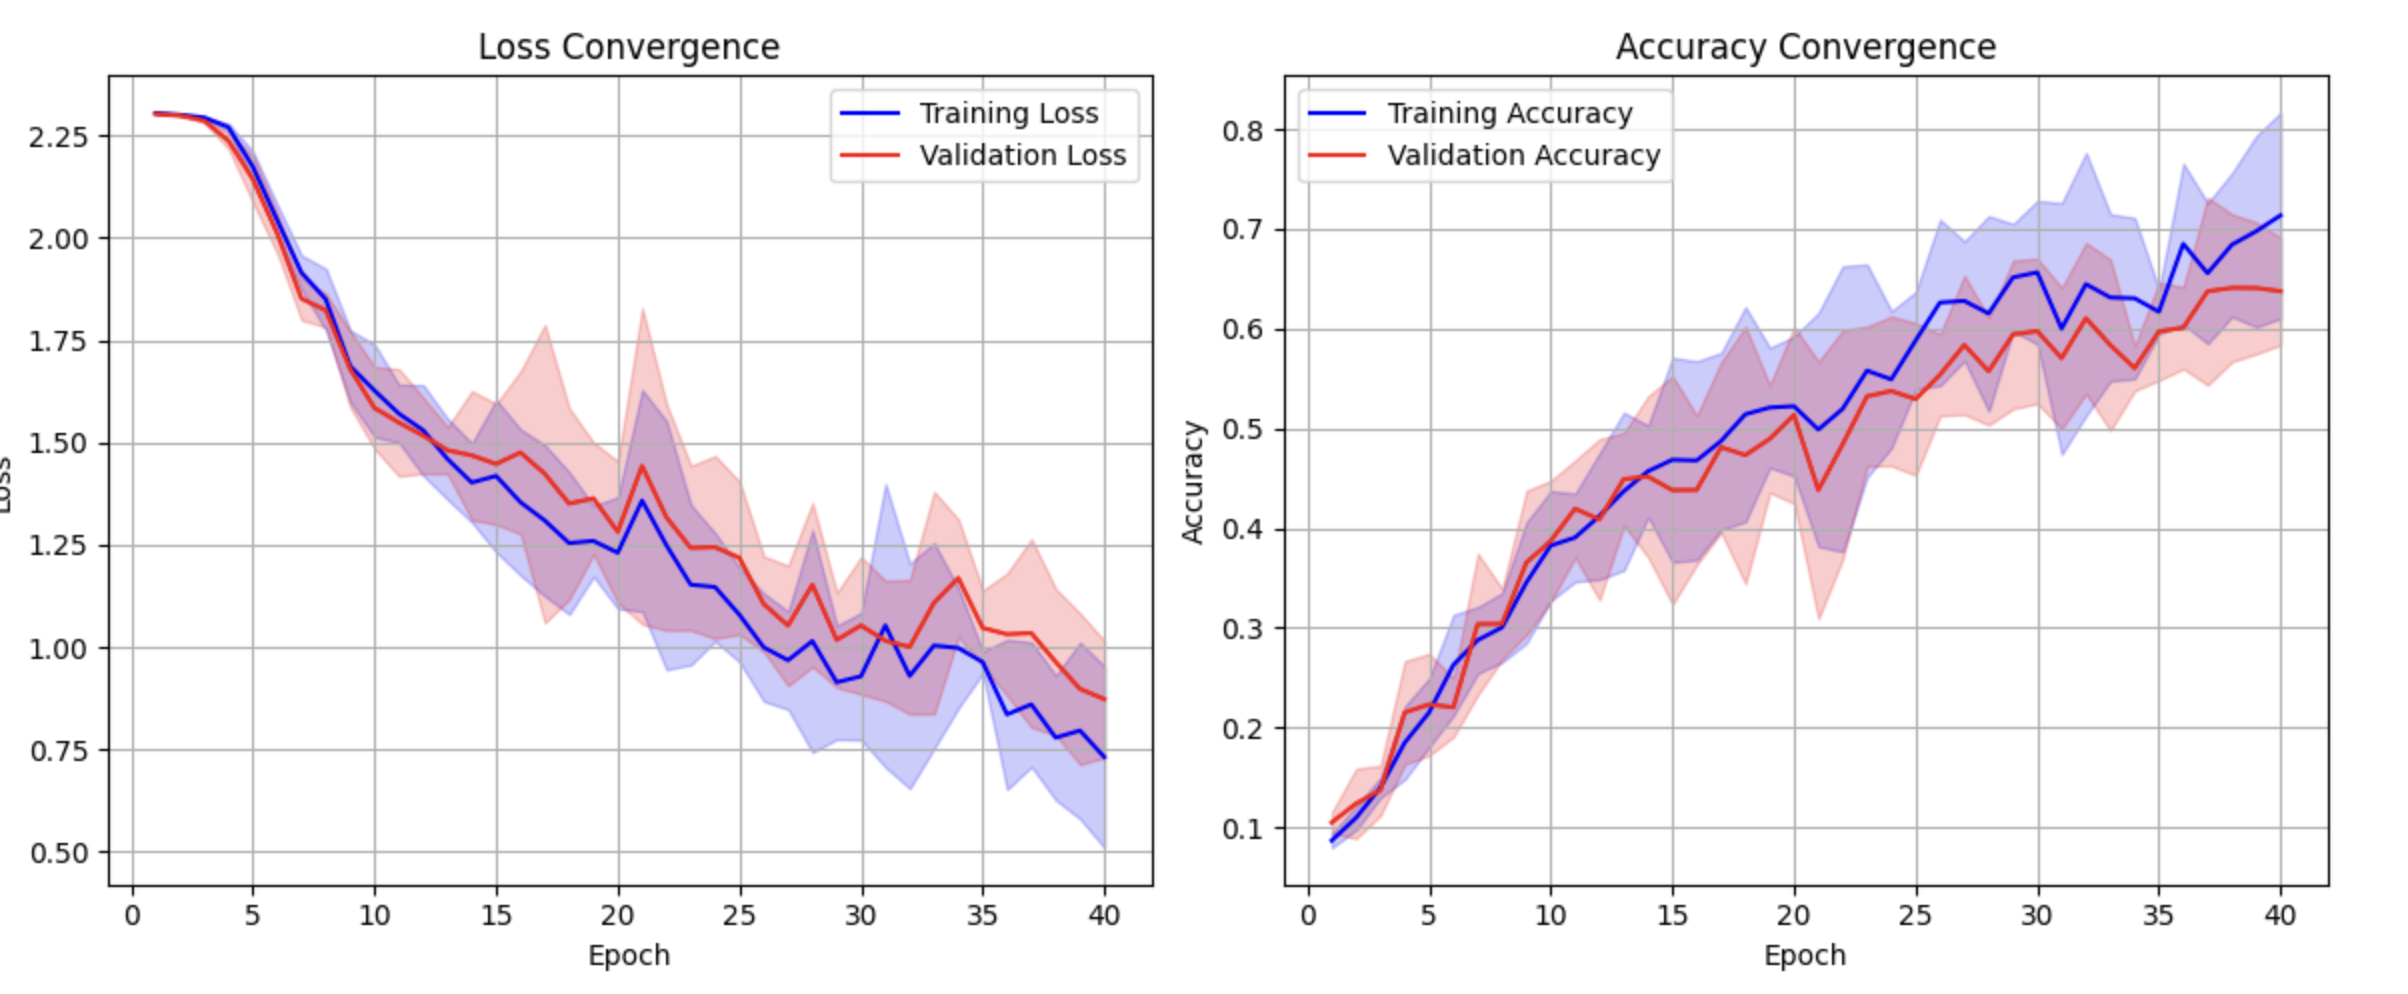

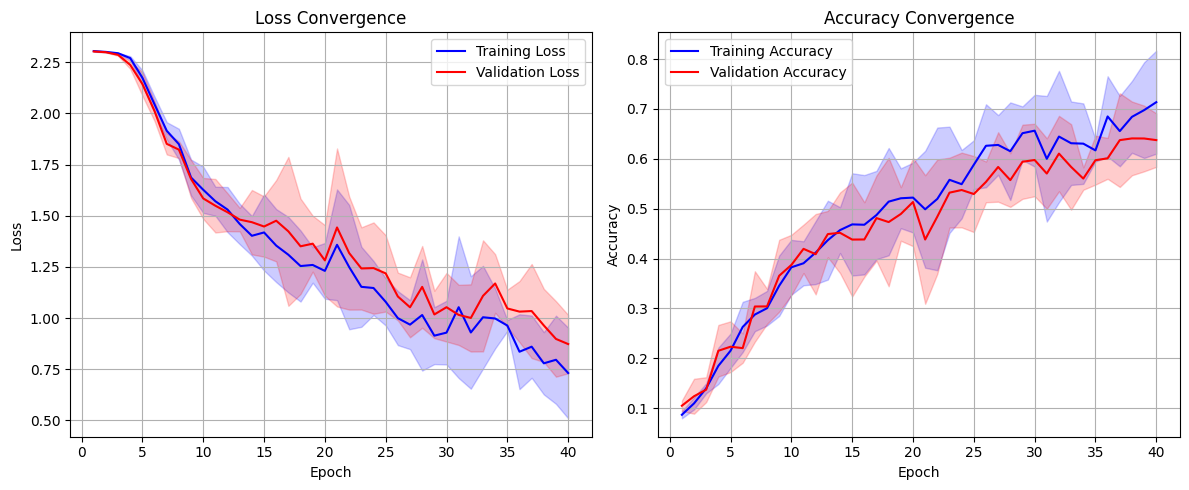

In [ ]:
# Calculate accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Training Accuracy: {accuracy:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes.values(), yticklabels=classes.values(), cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Training Data Confusion Matrix')
    plt.show()

    # Classification report
    print("Training Data Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes.values()))

# Model Evaluation and Analysis



Load the Pretrained Model from GitHub

In [ ]:
import torch
import os
import requests
from tqdm import tqdm

def download_model(url, save_path='best_model.pth'):
    if not os.path.exists(save_path):
        print(f"Downloading model from {url}...")
        response = requests.get(url, stream=True)
        total_size_in_bytes= int(response.headers.get('content-length', 0))
        block_size = 1024 #1 Kibibyte
        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
        with open(save_path, 'wb') as f:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()
        if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
            raise Exception("ERROR, something went wrong with the download")
        print(f"Model downloaded and saved to {save_path}")
    else:
        print(f"Model already exists at {save_path}")
    return save_path

#Load pretrained model
model_url = 'https://github.com/winstongarth/dl_coursework_2025_model/raw/refs/heads/main/best_model_fold_2.pth?download='
model_path = download_model(model_url)

100%|██████████| 47.2M/47.2M [00:00<00:00, 97.3MiB/s]

Model downloaded and saved to best_model.pth


Classification trial function

In [ ]:
def classify(input_tensor, model_path='best_model.pth', device=None):
    # Set device
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize the model
    model = CNN_LSTM(num_classes=10).to(device)

    # Load the pretrained weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Preprocess the input_tensor
    # Ensure the input is a tensor of shape (1, 3, 50, 128, 128)
    if input_tensor.shape != (50, 3, 128, 128):
        raise ValueError("Input tensor must have shape (50, 3, 128, 128)")

    # Add batch dimension
    input_tensor = input_tensor.unsqueeze(0).to(device)  # Shape: (1, 3, 50, 128, 128)

    with torch.no_grad():
        outputs = model(input_tensor)  # Shape: (1, 10)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

# Run classify function
predicted_class = classify(input, model_path=model_path) # Change input dir here
print(f"Predicted Class: {classes[predicted_class]}")

Testing code and Evaluation

Performance Results, tested on test dataset

1. **Overall Accuracy**: 0.6774, which is around the average training fold accuracy, indicating that the model is not overfitting

2. **Class-Specific Performance**:
   - Actions with distinctive full-body movements like "jump" and "bend" show the highest precision, which is as expected
   - While, more similar actions like "wave1" vs "wave2" show some confusion but still maintain good differentiation
   - The model performs consistently across classes, with no significant performance gaps

3. **Confusion Matrix Analysis**:
   - Minimal misclassification between visually distinct classes
   - Some expected confusion between similar motion patterns (e.g., "walk" vs "run")
   - No systematic bias toward any particular class



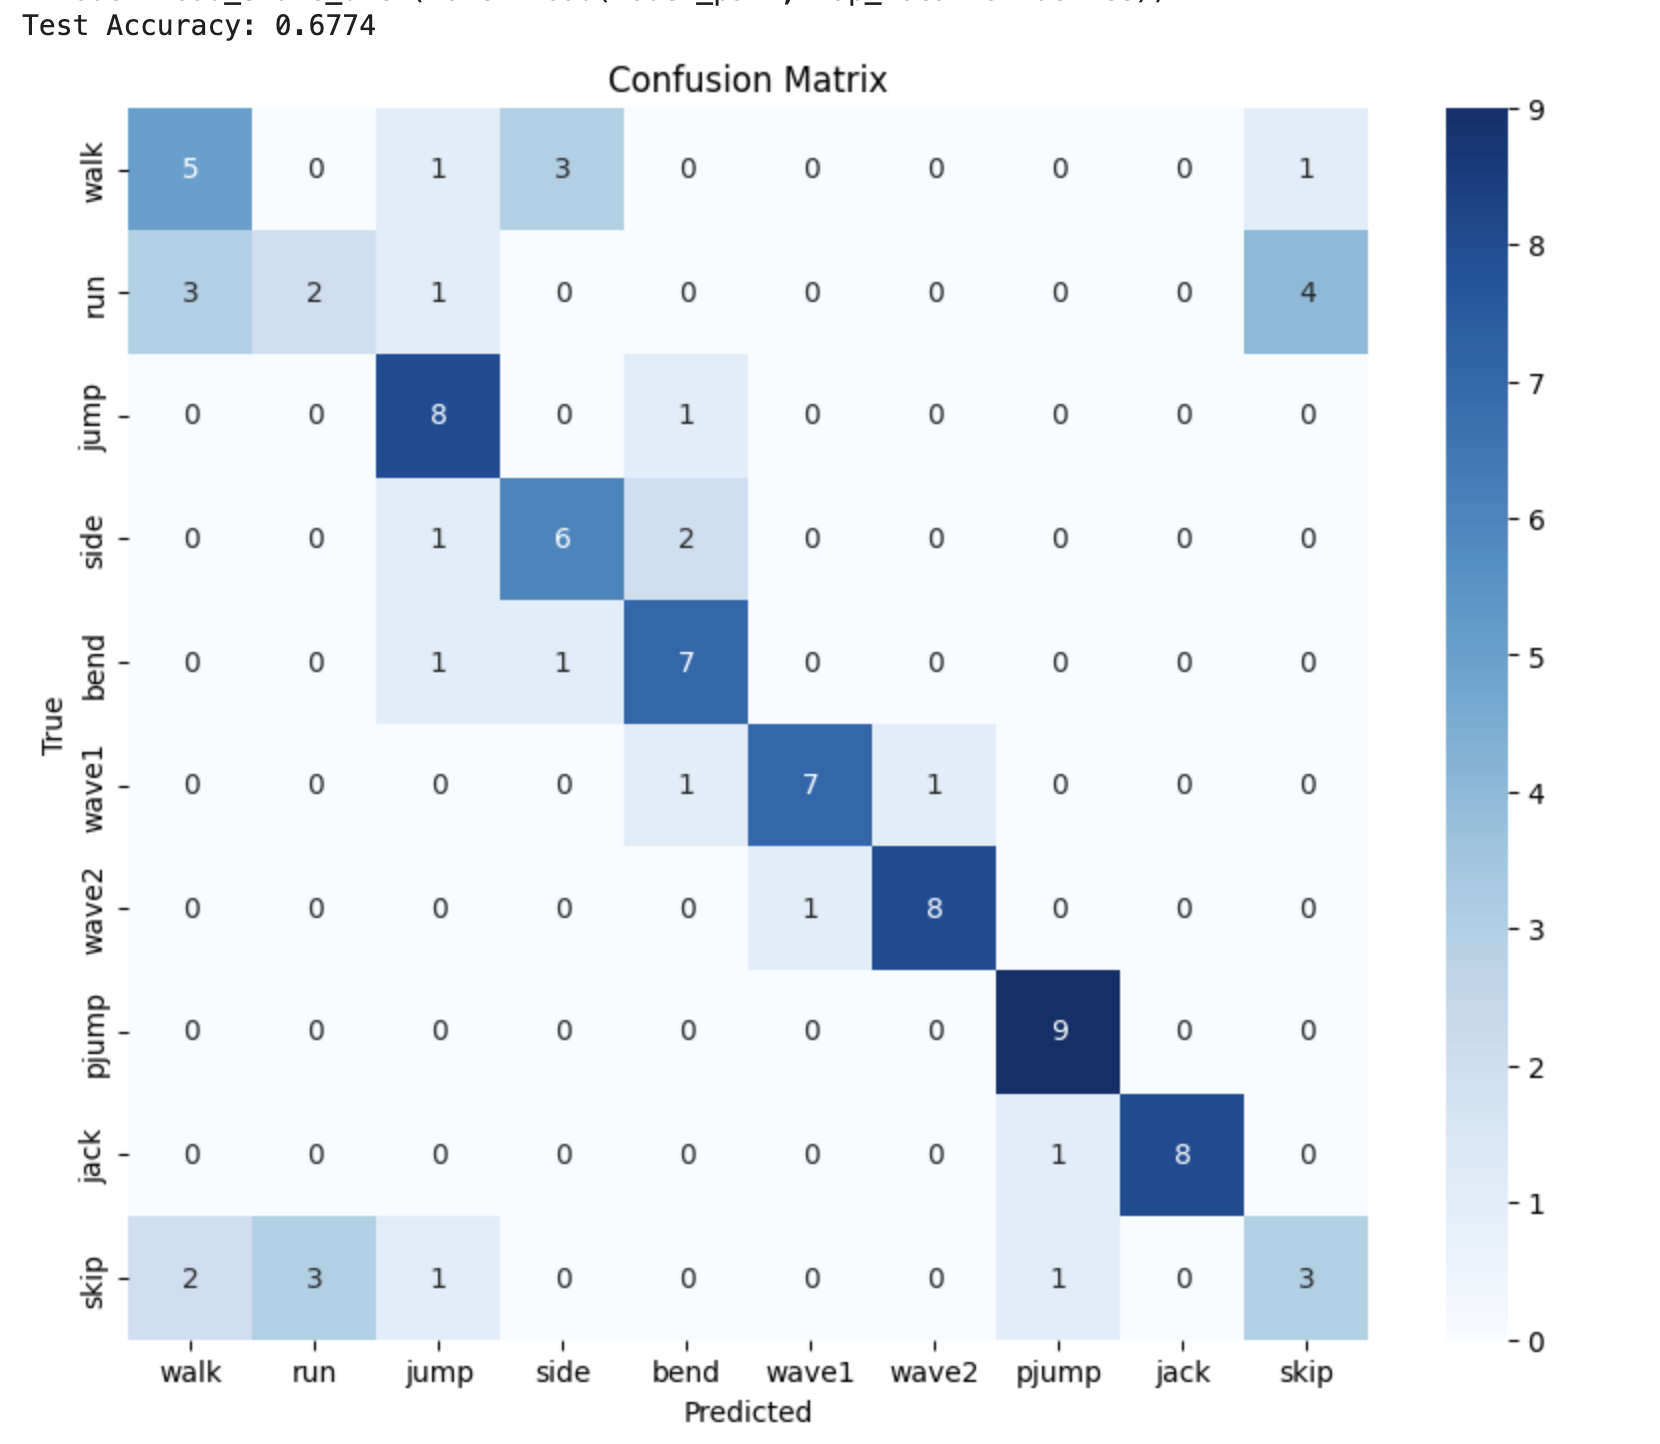

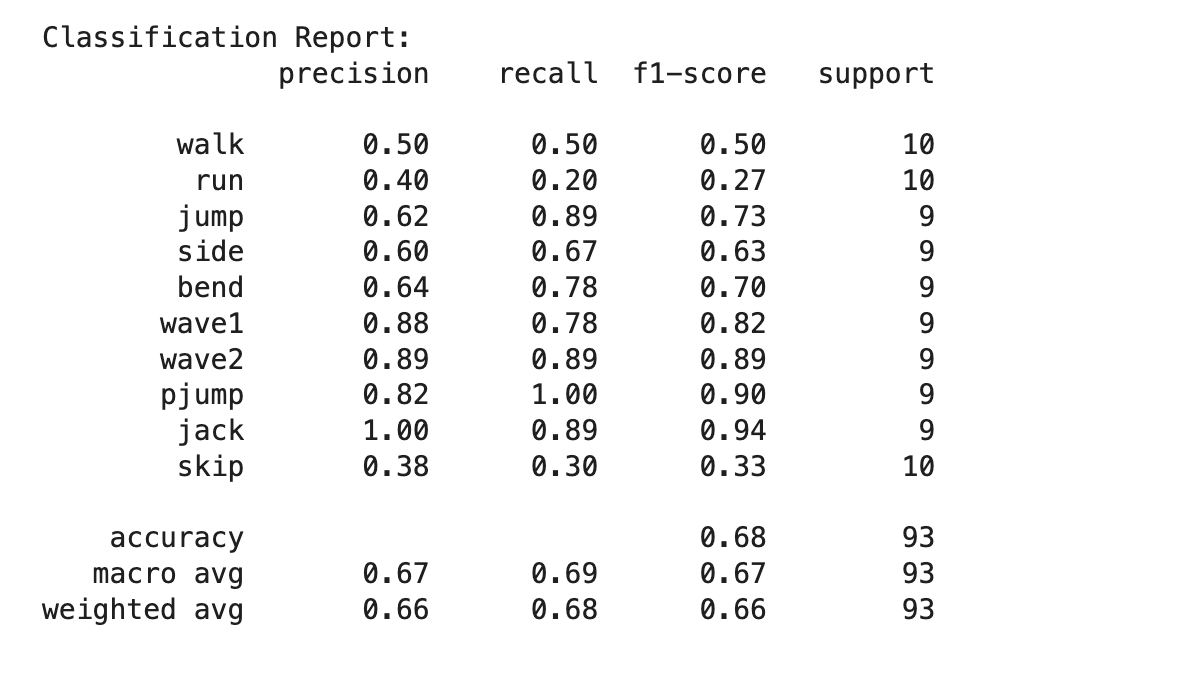

<ipython-input-52-12ac6b7a3dad>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Test Accuracy: 0.6774


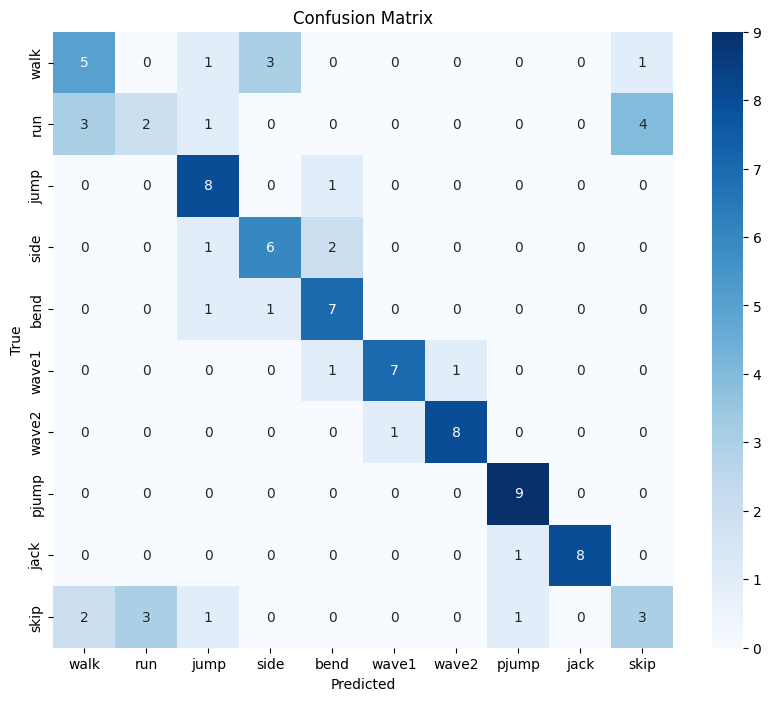

Classification Report:
              precision    recall  f1-score   support

        walk       0.50      0.50      0.50        10
         run       0.40      0.20      0.27        10
        jump       0.62      0.89      0.73         9
        side       0.60      0.67      0.63         9
        bend       0.64      0.78      0.70         9
       wave1       0.88      0.78      0.82         9
       wave2       0.89      0.89      0.89         9
       pjump       0.82      1.00      0.90         9
        jack       1.00      0.89      0.94         9
        skip       0.38      0.30      0.33        10

    accuracy                           0.68        93
   macro avg       0.67      0.69      0.67        93
weighted avg       0.66      0.68      0.66        93



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def test_model(model_path='best_model.pth', test_loader=None, device=None):
    if test_loader is None:
        raise ValueError("test_loader must be provided")

    # Set device
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize the model
    model = CNN_LSTM(num_classes=10).to(device)

    # Load the pretrained weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  # Shape: (batch, C, T, H, W)
            labels = labels.to(device)

            outputs = model(inputs)     # Shape: (batch, num_classes)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Test Accuracy: {accuracy:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes.values(), yticklabels=classes.values(), cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes.values()))


test_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.permute(0, 3, 1, 2).float() / 255.0),  # to (T, C, H, W)
    transforms.Lambda(lambda x: transforms.functional.center_crop(x, [144, 144])),  # Center crop
    transforms.Lambda(lambda x: transforms.functional.resize(x, (128, 128))),
    transforms.Lambda(lambda x: (x - x.mean(dim=(0,2,3), keepdim=True)) /
                              (x.std(dim=(0,2,3), keepdim=True) + 1e-6)),
    transforms.Lambda(lambda x: x.permute(1, 0, 2, 3))  # to (C, T, H, W)
])

# Create the DataLoader for test dataset
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

# Test the model
test_model(model_path=model_path, test_loader=test_loader)